In [11]:
import os
import pickle

import matplotlib.pyplot as plt

import numpy as np
import pymc3
import theano.tensor as tt

In [2]:
KB = 0.0019872041        # in kcal/mol/K
INJ_VOL = 1.2e-5         # in liter
CELL_CONCENTR = 0.1      # milli molar
SYRINGE_CONCENTR = 1.0   # milli molar

HEAT_FILE = "inputs/Mg1EDTAp1a.DAT"
OUT_DIR = "outputs"

In [3]:
def heats_TwoComponentBindingModel(V0, DeltaVn, P0, Ls, DeltaG, DeltaH, DeltaH_0, beta, N):
    """
    Expected heats of injection for two-component binding model.

    ARGUMENTS
    V0 - cell volume (liter)
    DeltaVn - injection volumes (liter)
    P0 - Cell concentration (millimolar)
    Ls - Syringe concentration (millimolar)
    DeltaG - free energy of binding (kcal/mol)
    DeltaH - enthalpy of binding (kcal/mol)
    DeltaH_0 - heat of injection (cal)
    beta - inverse temperature * gas constant (mole / kcal)
    N - number of injections

    Returns
    -------
    expected injection heats (calorie)

    """
    Kd = tt.exp(beta * DeltaG)   # dissociation constant (M)

    # Compute complex concentrations.
    # Pn[n] is the protein concentration in sample cell after n injections
    # (M)
    Pn = tt.zeros([N])
    # Ln[n] is the ligand concentration in sample cell after n injections
    # (M)
    Ln = tt.zeros([N])
    # PLn[n] is the complex concentration in sample cell after n injections
    # (M)
    PLn = tt.zeros([N])

    dcum = 1.0  # cumulative dilution factor (dimensionless)
    for n in range(N):
        # Instantaneous injection model (perfusion)
        # dilution factor for this injection (dimensionless)
        d = 1.0 - (DeltaVn[n] / V0)
        dcum *= d  # cumulative dilution factor
        # total quantity of protein in sample cell after n injections (mol)
        P = V0 * P0 * 1.e-3 * dcum
        # total quantity of ligand in sample cell after n injections (mol)
        L = V0 * Ls * 1.e-3 * (1. - dcum)
        
        # complex concentration (M)
        PLn = tt.set_subtensor(PLn[n], (0.5 / V0 * ((P + L + Kd * V0) - tt.sqrt((P + L + Kd * V0) ** 2 - 4 * P * L) )))

        # free protein concentration in sample cell after n injections (M)
        Pn = tt.set_subtensor(Pn[n], P / V0 - PLn[n])

        # free ligand concentration in sample cell after n injections (M)
        Ln = tt.set_subtensor(Ln[n], L / V0 - PLn[n])

    # Compute expected injection heats.
    # q_n_model[n] is the expected heat from injection n
    q_n = tt.zeros([N])
    # Instantaneous injection model (perfusion)
    # first injection
    q_n = tt.set_subtensor(q_n[0], (DeltaH * V0 * PLn[0])*1000. + DeltaH_0)

    for n in range(1, N):
        d = 1.0 - (DeltaVn[n] / V0)  # dilution factor (dimensionless)
        # subsequent injections
        q_n = tt.set_subtensor(q_n[n], (DeltaH * V0 * (PLn[n] - d * PLn[n - 1])) * 1000. + DeltaH_0)

    return q_n


def logsigma_guesses(q_n_cal):
    log_sigma_guess = np.log(q_n_cal[-4:].std())
    log_sigma_min = log_sigma_guess - 10
    log_sigma_max = log_sigma_guess + 5
    return log_sigma_min, log_sigma_max


def deltaH0_guesses(q_n_cal):
    heat_interval = (q_n_cal.max() - q_n_cal.min())
    DeltaH_0_min = q_n_cal.min() - heat_interval
    DeltaH_0_max = q_n_cal.max() + heat_interval
    return DeltaH_0_min, DeltaH_0_max


def lognormal_prior(name, stated_value, uncertainty):
    """
    Define a pymc3 prior for a deimensionless quantity
    :param name: str
    :param stated_value: float
    :uncertainty: float
    :rerurn: pymc3.Lognormal
    """
    m = stated_value
    v = uncertainty ** 2
    return pymc3.Lognormal(name,
                           mu=tt.log(m / tt.sqrt(1 + (v / (m ** 2)))),
                           tau=1.0 / tt.log(1 + (v / (m ** 2))),
                           testval=m)


def uniform_prior(name, lower, upper):
    """
    :param name: str
    :param lower: float
    :param upper: float
    :return: pymc3.Uniform
    """
    return pymc3.Uniform(name, lower=lower, upper=upper)

    
def make_TwoComponentBindingModel(q_actual_cal, injection_volumes, 
                                  cell_concentration, syringe_concentration,
                                  cell_volume=0.001434,
                                  temperature=298.15,
                                  dcell=0.1, dsyringe=0.1,
                                  uniform_P0=False, P0_min=None, P0_max=None, 
                                  uniform_Ls=False, Ls_min=None, Ls_max=None):
    """
    to create a pymc3 model
    :param q_actual_cal: observed heats in calorie, array-like
    :param injection_volumes: injection volumes in liter, array-like
    :param cell_concentration: concentration of the sample cell in milli molar, float
    :param syringe_concentration: concentration of the syringe in milli molar, float
    :param cell_volume: volume of sample cell in liter, float
    :param temperature: temprature in kelvin, float
    :param dcell: relative uncertainty in cell concentration, float
    :param dsyringe: relative uncertainty in syringe concentration, float
    :param uniform_P0: if True, use uniform prior for cell concentration, bool
    :param P0_min: only use if uniform_P0 is True, float
    :param P0_max: only use if uniform_P0 is True, float
    :param uniform_Ls: if True, use uniform prior for syringe concentration, bool
    :param Ls_min: only use if uniform_Ls is True, float
    :param Ls_max: only use if uniform_Ls is True, float
    
    :return: an instance of pymc3.model.Model
    """
    assert len(q_actual_cal) == len(injection_volumes), "q_actual_cal and injection_volumes must have the same len."
    
    if uniform_P0 and (P0_min is None or P0_max is None):
        raise ValueError("If uniform_P0 is True, both P0_min and P0_max must be provided")
    
    if uniform_Ls and (Ls_min is None or Ls_max is None):
        raise ValueError("If uniform_Ls is True, both Ls_min and Ls_max must be provided")
        
    V0 = cell_volume

    DeltaVn = injection_volumes

    beta = 1 / KB / temperature
    n_injections = len(q_actual_cal)
    
    DeltaH_0_min, DeltaH_0_max = deltaH0_guesses(q_actual_cal)
    log_sigma_min, log_sigma_max = logsigma_guesses(q_actual_cal)

    stated_P0 = cell_concentration
    print("Stated P0", stated_P0)
    uncertainty_P0 = dcell * stated_P0

    stated_Ls = syringe_concentration
    print("Stated Ls", stated_Ls)
    uncertainty_Ls = dsyringe * stated_Ls
    
    with pymc3.Model() as model:

        # prior for receptor concentration
        if uniform_P0:
            print("Uniform prior for P0")
            P0 = uniform_prior("P0", lower=P0_min, upper=P0_max)
        else:
            print("LogNormal prior for P0")
            P0 = lognormal_prior("P0", stated_value=stated_P0, uncertainty=uncertainty_P0)

        # prior for ligand concentration
        if uniform_Ls:
            print("Uniform prior for Ls")
            Ls = uniform_prior("Ls", lower=Ls_min, upper=Ls_max)
        else:
            print("LogNormal prior for Ls")
            Ls = lognormal_prior("Ls", stated_value=stated_Ls, uncertainty=uncertainty_Ls)

        # prior for DeltaG
        DeltaG = uniform_prior("DeltaG", lower=-40., upper=40.)

        # prior for DeltaH
        DeltaH = uniform_prior("DeltaH", lower=-100., upper=100.)

        # prior for DeltaH_0
        DeltaH_0 = uniform_prior("DeltaH_0", lower=DeltaH_0_min, upper=DeltaH_0_max)

        # prior for log_sigma
        log_sigma = uniform_prior("log_sigma", lower=log_sigma_min, upper=log_sigma_max)
        sigma_cal = tt.exp(log_sigma)

        q_model_cal = heats_TwoComponentBindingModel(V0, DeltaVn, P0, Ls, DeltaG, 
                                                     DeltaH, DeltaH_0, beta, n_injections)

        q_obs = pymc3.Normal("q_obs", mu=q_model_cal, sd=sigma_cal, observed=q_actual_cal)

    return model


In [4]:
def load_heat_micro_cal(origin_heat_file):
    """
    :param origin_heat_file: str, name of heat file
    :return: 1d ndarray, heats in micro calorie
    """

    heats = []
    with open(origin_heat_file) as handle:
        handle.readline()
        for line in handle:
            if len(line.split()) == 6:
                heats.append(np.float(line.split()[0]))

    return np.array(heats)


def extract_samples_from_trace(trace, thin=1, burn=0):
    params = {var: trace.get_values(var, thin=thin, burn=burn) for var in trace.varnames}
    return params

In [5]:
q_actual_micro_cal = load_heat_micro_cal(HEAT_FILE)
q_actual_cal = q_actual_micro_cal * 1e-6
q_actual_cal

array([-2.772430e-05, -2.899697e-05, -2.892312e-05, -2.884158e-05,
       -2.882591e-05, -2.888749e-05, -2.800774e-05, -2.733818e-05,
       -2.065130e-05, -9.139800e-06, -3.761440e-06, -1.943890e-06,
       -1.627770e-06, -1.045790e-06, -1.054640e-06, -1.034880e-06,
       -1.130120e-06, -1.036560e-06, -7.545200e-07, -9.018900e-07,
       -9.904100e-07, -8.517100e-07, -9.327900e-07])

In [6]:
n_injections = len(q_actual_cal)
print("# injections:", n_injections)
injection_volumes = [INJ_VOL for _ in range(n_injections)]

model = make_TwoComponentBindingModel(q_actual_cal, injection_volumes, CELL_CONCENTR, SYRINGE_CONCENTR)

# injections: 23
Stated P0 0.1
Stated Ls 1.0
LogNormal prior for P0
LogNormal prior for Ls


In [7]:
# To generate initial values for NUTS. If we dont do this NUTS sampler can crash
with model:
    step = pymc3.Metropolis()
    _trace = pymc3.sample(draws=10_000, step=step, cores=2, chains=2)
    samples = extract_samples_from_trace(_trace)
    start = {k: samples[k][-1] for k in samples}

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [log_sigma]
>Metropolis: [DeltaH_0]
>Metropolis: [DeltaH]
>Metropolis: [DeltaG]
>Metropolis: [Ls]
>Metropolis: [P0]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:26<00:00, 780.65draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [8]:
start

{'P0_log__': -2.1407125764931516,
 'Ls_log__': 0.3995764562093969,
 'DeltaG_interval__': -0.44542574075714303,
 'DeltaH_interval__': -0.03123257738309927,
 'DeltaH_0_interval__': 0.6748792828857128,
 'log_sigma_interval__': 1.2818424742001904,
 'P0': 0.11757103480976358,
 'Ls': 1.4911929783437525,
 'DeltaG': -8.764089122976955,
 'DeltaH': -1.5615019375211432,
 'DeltaH_0': -1.0995142502658964e-06,
 'log_sigma': -15.064319843472584}

In [9]:
# run NUTS
with model:
    step = pymc3.NUTS()
    trace = pymc3.sample(draws=1000, step=step, start=start, cores=2, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_sigma, DeltaH_0, DeltaH, DeltaG, Ls, P0]
Sampling 2 chains: 100%|██████████| 3000/3000 [01:32<00:00, 32.42draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [10]:
pickle.dump(model, open(os.path.join(OUT_DIR, "model.pickle"), "wb"))
pickle.dump(trace, open(os.path.join(OUT_DIR, "trace.pickle"), "wb"))

//anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


<Figure size 432x288 with 0 Axes>

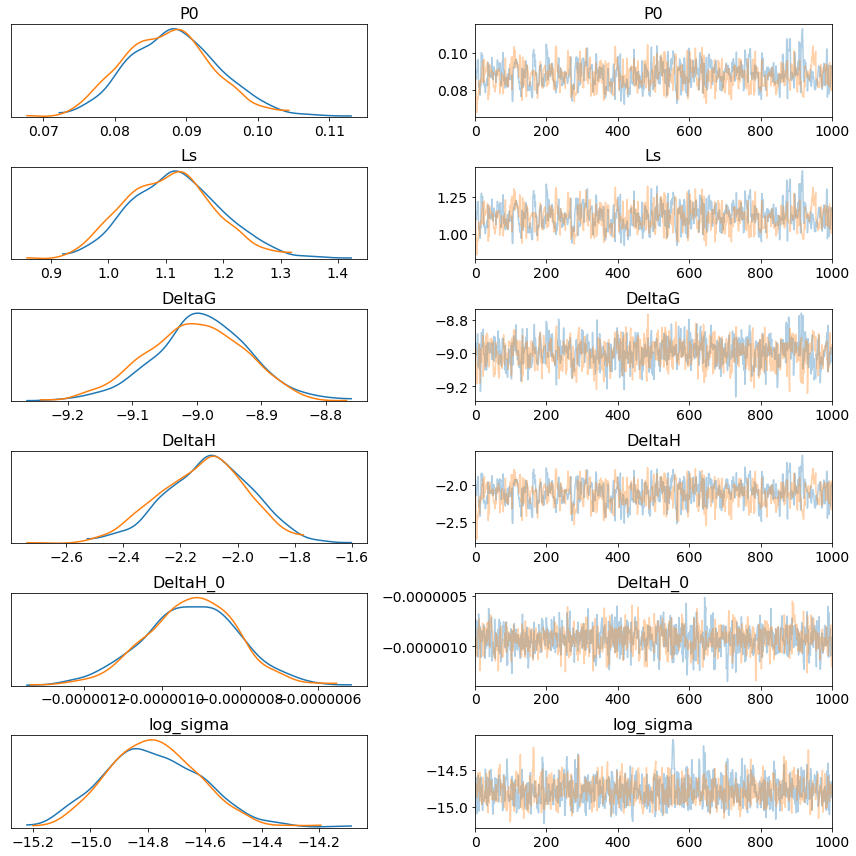

In [12]:
plt.figure()
pymc3.traceplot(trace)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "traceplot.pdf"))